In [9]:
from pathlib import Path

import torch
from datasets import load_from_disk, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    DataCollatorForLanguageModeling,
)

from typing import List

from peft import (
    PeftModel,
    LoraConfig,
    PromptTuningConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

In [2]:
BASE_MODEL = "HuggingFaceTB/SmolLM2-135M-Instruct"
DEVICE = "cpu" if torch.backends.mps.is_available() else "cpu"
PROJECT_DIR = Path("rp_project")  # everything lands in here
PROJECT_DIR.mkdir(exist_ok=True)

In [3]:
def _load_base_model(model_name: str = BASE_MODEL):

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map=DEVICE,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

Training characters:   0%|          | 0/1 [00:00<?, ?it/s]


Training cricket...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Will train for 37 steps
Starting training...


Step,Training Loss
10,2.793600
20,2.632900
30,2.730300
40,2.635700
50,2.497700
60,2.620700
70,2.513000
80,2.454000
90,2.288500
100,2.424800


Training complete!


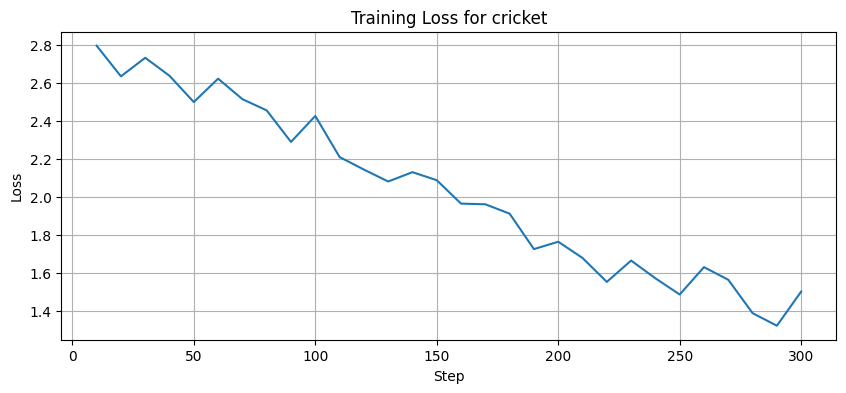

Model saved to rp_project/adapters/cricket


In [5]:
MAIN_CHAR_NAMES: List[str] = ["cricket"]  # one sub-folder per char in data/tokenised
LORA_OUTPUT = PROJECT_DIR / "adapters"

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

for char in tqdm(MAIN_CHAR_NAMES, desc="Training characters"):
    print(f"\nTraining {char}...")
    dataset_dir = Path(f"data/tokenized/{char}")
    output_dir = LORA_OUTPUT / char
    output_dir.mkdir(parents=True, exist_ok=True)

    model, tokenizer = _load_base_model()


    model = prepare_model_for_kbit_training(model)

    lora_cfg = LoraConfig(
        r=4,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "fc_in", "fc_out"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, lora_cfg)

    dataset = load_from_disk(dataset_dir)
    total_steps = len(dataset) * 3 // (4 * 8)  # num_samples * epochs / (batch_size * grad_accum)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
        pad_to_multiple_of=8,
    )

    # Track loss for plotting
    class LossTracker:
        def __init__(self):
            self.losses = []
            self.steps = []
            
        def log(self, step, loss):
            self.losses.append(loss)
            self.steps.append(step)
            
        def plot(self):
            plt.figure(figsize=(10, 4))
            plt.plot(self.steps, self.losses)
            plt.title(f"Training Loss for {char}")
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.show()
            
    loss_tracker = LossTracker()

    class LossCallback(TrainerCallback):
        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs and "loss" in logs:
                loss_tracker.log(state.global_step, logs["loss"])

    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        learning_rate=5e-5,
        fp16=False,
        optim="adamw_torch",
        logging_steps=10,
        save_strategy="epoch",
        report_to="none",
        # MPS optimizations
        dataloader_pin_memory=False,  # Disable pin memory for MPS
        dataloader_num_workers=0,     # Avoid multiprocessing issues on Mac
        # Memory optimizations
        max_grad_norm=1.0,            # Gradient clipping
        warmup_steps=10,              # Quick warmup
    )

    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=dataset,
        data_collator=data_collator,
        callbacks=[LossCallback()],
    )
    
    print("Starting training...")
    trainer.train()
    print("Training complete!")
    
    # Plot the loss curve
    loss_tracker.plot()
    
    model.save_pretrained(output_dir)
    print(f"Model saved to {output_dir}")

In [ ]:
SCENE_ID   = "sky_temple_heist"
RAW_PATH   = f"data/scene_{SCENE_ID}/*.jsonl"
OUT_DIR    = Path(f"data/tokenized/{SCENE_ID}")
MAXLEN     = 1024

tok = AutoTokenizer.from_pretrained(BASE_MODEL)

def process(example):
    chat_text = tok.apply_chat_template(example["messages"], tokenize=False)
    ids = tok(chat_text, add_special_tokens=False,
              truncation=True, max_length=MAXLEN)["input_ids"]
    return {"input_ids": ids}

ds = load_dataset("json", data_files=RAW_PATH, split="train")
ds = ds.map(process, remove_columns=ds.column_names)
OUT_DIR.mkdir(parents=True, exist_ok=True)
ds.save_to_disk(OUT_DIR)

In [ ]:
base_model, base_tok = _load_base_model()

prompt_cfg = PromptTuningConfig(
    task_type="CAUSAL_LM",
    tokenizer_name_or_path=BASE_MODEL,
    num_virtual_tokens=16,         # 16-32 is typical
)
prompt_model = get_peft_model(base_model, prompt_cfg)

dataset = load_from_disk(f"data/tokenized/{SCENE_ID}")
collator = DataCollatorForLanguageModeling(
    tokenizer=base_tok, mlm=False, pad_to_multiple_of=8
)

args = TrainingArguments(
    output_dir=f"rp_project/prompts/{SCENE_ID}",
    per_device_train_batch_size=8,
    num_train_epochs=5,
    learning_rate=1e-3,
    fp16=False,
    logging_steps=20,
    save_strategy="epoch",
    report_to="none",
)

trainer = Trainer(model=prompt_model,
                  args=args,
                  train_dataset=dataset,
                  data_collator=collator)
trainer.train()
prompt_model.save_pretrained(f"rp_project/prompts/{SCENE_ID}")

# Continuous Training

This should help keep the character updated.

In [ ]:
from peft import PeftModel


CHATLOG_DIR = Path("chatlogs")

def incremental_update(char_name: str, chatlog_jsonl: Path, steps: int = 50):
    """Fine-tune the char's LoRA a few extra steps on fresh dialogue."""
    base, tokenizer = _load_base_model()
    lora_model = PeftModel.from_pretrained(base, LORA_OUTPUT / char_name)

    # Turn new chatlog into tokenised dataset on the fly (reuse prepare_dataset helpers)
    tmp_ds = load_from_disk(chatlog_jsonl)  # assume you ran prepare_dataset earlier

    # Create data collator for handling variable-length sequences
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,  # We're doing causal LM, not masked LM
        pad_to_multiple_of=8,  # Optional: pad to multiple of 8 for efficiency
    )

    args = TrainingArguments(
        output_dir=LORA_OUTPUT / char_name,
        per_device_train_batch_size=4,
        max_steps=steps,
        learning_rate=2e-5,
        optim="adamw_torch",
        logging_steps=10,
        resume_from_checkpoint=None,
        report_to="none",
    )
    trainer = Trainer(
        model=lora_model, 
        args=args, 
        train_dataset=tmp_ds,
        data_collator=data_collator,
    )
    trainer.train()
    # overwrite adapter weights in place
    lora_model.save_pretrained(LORA_OUTPUT / char_name)

# Test the character

This small helper can be used to load character loras as well as scenario embeddings.

In [7]:
def load_character(char_name: str, scene_id: str | None = None):
    base, tok = _load_base_model()
    lora = PeftModel.from_pretrained(base, LORA_OUTPUT / char_name)
    if scene_id:
        prompt_cfg = PromptTuningConfig(
            task_type="CAUSAL_LM",
            num_virtual_tokens=16,
            tokenizer_name_or_path=BASE_MODEL,
        )
        lora = get_peft_model(lora, prompt_cfg)
        # # If we want to load a specific scene prompt
        # lora.load_adapter("rp_project/prompts/sky_temple_heist", adapter_name="scene_prompt")
    return lora, tok

In [12]:
# example
model, tokenizer = load_character("cricket") # or load_character("cricket", scene_id="sky_temple_heist")

prompt = "User: What will you do next?\n###"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**inputs, max_new_tokens=40)[0]))

User: What will you do next?
### 1. 100% Success

#### 100% Success

#### 100% Success

#### 100% Success

#### 
